In [289]:
import os
import sys

sys.path.insert(0, '/home/lclaeys/eigenfunction-solver')


In [290]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from tqdm import tqdm

In [291]:
from src.energy.quadratic import QuadraticEnergy
from src.eigensolver.neural.network.feedforward import FeedForwardNetwork, ConstantFFN
from src.eigensolver.neural.loss.orth_loss import BasicOrthogonalityLoss, CovOrthogonalityLoss
from src.eigensolver.neural.loss.variational_loss import VariationalLoss

In [292]:
dim = 1
m = 5
N = 50000
energy = QuadraticEnergy(np.eye(dim))
x = torch.tensor(energy.exact_sample((N,)),dtype=torch.float, requires_grad = True)

In [293]:
model = ConstantFFN([dim,200,200,2000,200,m])

In [294]:
var_loss = VariationalLoss()
orth_loss = BasicOrthogonalityLoss()

In [295]:
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)


In [296]:
grad_outputs = torch.eye(m)[:,None,:].expand([m,N,m])

In [297]:
beta = 0.1
orth_cost = []
var_cost = []
for epoch in range(10000):  # Train for 100 epochs
    x = torch.tensor(energy.exact_sample((N,)),dtype=torch.float, requires_grad = True)
    optimizer.zero_grad()  # Clear gradients
    fx = model(x)  # Forward pass
    grad_fx = torch.autograd.grad(outputs = fx, inputs = x, grad_outputs = grad_outputs, is_grads_batched=True, create_graph=True)[0].transpose(0,1)
    loss_1 = var_loss(grad_fx)  # Variational loss
    loss_2 = orth_loss(fx)
    
    orth_cost.append(loss_2)
    var_cost.append(loss_1)

    loss = beta*loss_1 + loss_2
    loss.backward()  # Backward pass
    optimizer.step()  # Update model parameters
    scheduler.step()
    
    # Print loss every 10 epochs
    if (epoch + 1) % 2 == 0:
        print(f"Epoch {epoch + 1}, lr: {scheduler.get_last_lr()[0]:.2e}, Loss: {loss.item():.3e}, Loss_1: {loss_1.item():.3e}, Loss_2: {loss_2.item():.3e}", end = '\r')



RuntimeError: If `is_grads_batched=True`, we interpret the first dimension of each grad_output as the batch dimension. The sizes of the remaining dimensions are expected to match the shape of corresponding output, but a mismatch was detected: grad_output[0] has a shape of torch.Size([5]) and output[0] has a shape of torch.Size([50000, 200]). If you only want some tensors in `grad_output` to be considered batched, consider using vmap.

(0.0, 10.0)

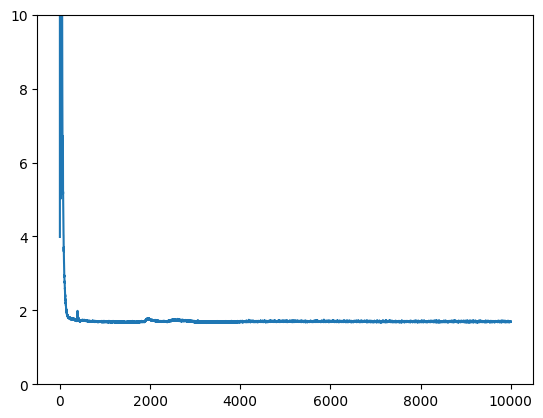

In [280]:
plt.plot((torch.tensor(var_cost)*beta+torch.tensor(orth_cost)).detach())

plt.ylim(0,10)

(0.0, 20.0)

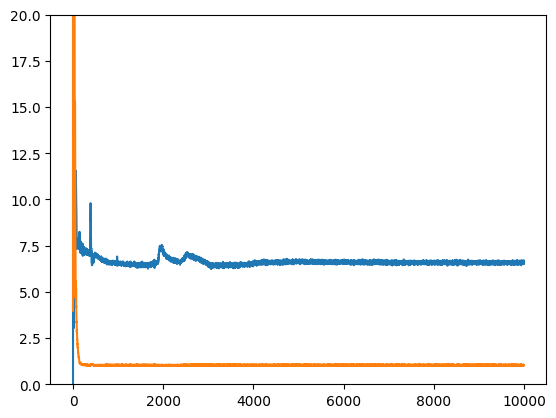

In [281]:
plt.plot(torch.tensor(var_cost).detach())
plt.plot(torch.tensor(orth_cost).detach())

plt.ylim(0,20)

In [282]:
x_eval = torch.linspace(-2,2,10000)[:,None]
fx_eval = model(x_eval).detach()
eigfuncs = torch.tensor(energy.exact_eigfunctions(x_eval.numpy(), m),dtype=torch.float)

In [283]:
# deconstruct

x_pca = torch.tensor(energy.exact_sample((N,)),dtype=torch.float)
fx_pca = model(x_pca).detach()[:,1:]

cov = torch.cov(fx_pca.T)

In [284]:
D, U = torch.linalg.eigh(cov)
eigvals = 2/beta*(1-D)
rotation = torch.diag(1/D**(1/2))@U.T

In [285]:
fx_eval[:,1:] = fx_eval[:,1:]@rotation

In [286]:
_, indices = torch.sort(eigvals)
fx_eval[:,1:] = fx_eval[:,1+indices]

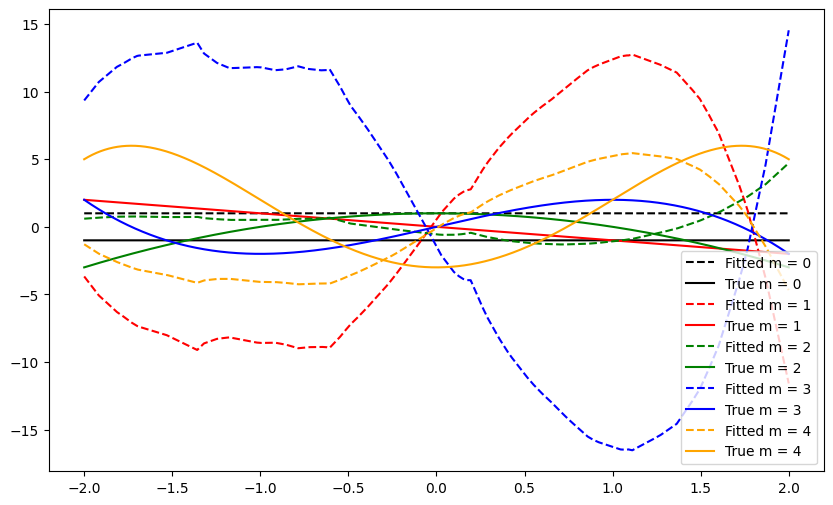

In [287]:
colors = ['black', 'red', 'green', 'blue', 'orange']
# Create the plot
plt.figure(figsize=(10, 6))

for i in range(m):
    # Plot array1 with full lines
    plt.plot(x_eval, fx_eval[:, i], color=colors[i], label=f'Fitted m = {i}', linestyle='--')
    
    # Plot array2 with dashed lines
    plt.plot(x_eval, -eigfuncs[:, i], color=colors[i], label=f'True m = {i}')

# Add legend and labels
plt.legend()
#plt.ylim(-2,2)

In [288]:
eigvals

tensor([19.9600,  5.4686,  2.6006,  1.1601])